In [1]:
import numpy as np
import pandas as pd
import os, subprocess, shutil
import matplotlib.pyplot as plt
import pyvista as pv
from myusefultools.parser import getVTKList
import xarray as xr

REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

caseName   = "constantHead"
PATH_TO_VTK = f"{caseName}/VTK"

In [48]:
def get_mean_velocity() -> np.float64:

    ## Extract VTK results (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    nTimes = len(all_vtk_paths)

    ## Initialize array to store data
    results = np.zeros([nTimes])

    ## Extract field for each vtk field
    for t,vtk in enumerate(all_vtk_paths):
        mesh = pv.read(vtk)
        integrated_volume = mesh.integrate_data()
        volume = integrated_volume['Volume'][0]
        z_velocity = integrated_volume['U'][0,-1]
        results[t] = z_velocity/volume

    return results #(meanU, stdU)

In [151]:
def get_probe(field) -> np.float64:

    point = np.array([[0.04, 0.04, 0.00]])

    ## Extract VTK results (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    nTimes = len(all_vtk_paths)

    ## Initialize array to store data
    results = np.zeros([nTimes])

    ## Extract field for each vtk field
    for t,vtk in enumerate(all_vtk_paths):
        mesh = pv.read(vtk)
        probing = mesh.probe(point)
        results[t] = probing[field][0]

    return results 

In [87]:
def get_total_biomass(field:str) -> np.float64:

    ## Extract VTK results (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    nTimes = len(all_vtk_paths)

    ## Initialize array to store data
    results = np.zeros([nTimes])

    ## Extract field for each vtk field
    for t,vtk in enumerate(all_vtk_paths):
        mesh = pv.read(vtk)
        integrated_volume = mesh.integrate_data()
        total_field = integrated_volume[field][0]
        results[t] = total_field

    return results #(meanU, stdU)

In [54]:
def getAllMeshes(field:str):
    ## Extract VTK result (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    nTimes = len(all_vtk_paths)
    times = [float(t) for t in subprocess.check_output("foamListTimes", cwd=f"./{caseName}").decode("utf-8").splitlines() if t[0:2].isnumeric()]

    ## Use dimensions from the first VTK
    mesh = pv.read(all_vtk_paths[0])
    line = pv.Line(
        a:=[0, 0, mesh.bounds[5]],
        b:=[0, 0, mesh.bounds[2]])
    sample = mesh.sample_over_line(a,b)
    nPoints = len(sample[field])

    ## Initialize array to store data
    results = np.zeros([nPoints, nTimes])

    ## Extract field for each vtk field
    for t,vtk in enumerate(all_vtk_paths):
        mesh = pv.read(vtk)
        sample = mesh.sample_over_line(a,b)
        results[:,t] = sample[field]

    data = xr.DataArray(
        results, 
        dims=("z","t"), 
        coords={
            "z": sample.points[:,2], 
            "t": times})
 
    return data

In [154]:
## Careful with this gradient, might need a very fine mesh 
## to solve for such an abrupt change

scalarName = "DOC"
scalar = getAllMeshes(scalarName)

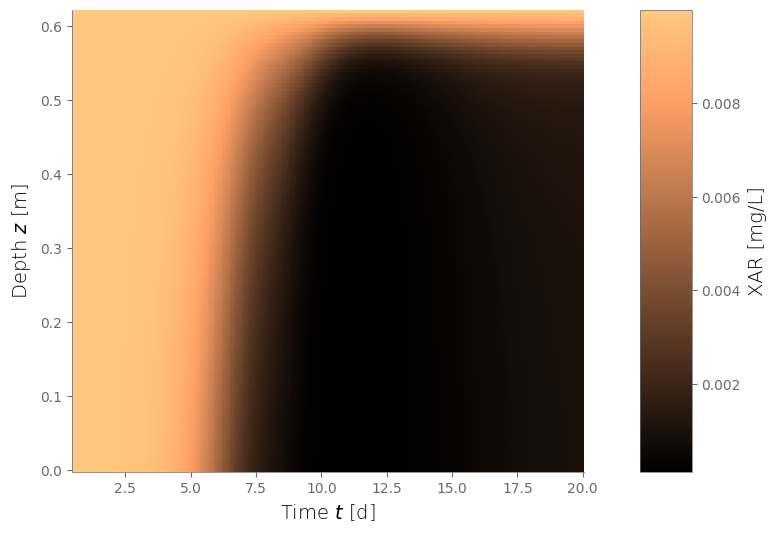

In [155]:
import matplotlib.colors as colors

fig, (ax,cax) = plt.subplots(1,2, figsize=[8,6], gridspec_kw={"width_ratios":[5,0.5]}, sharex=False)
fig.set_facecolor("#ffffff00")

igt = 4  # Ignore the first timesteps for plor

img = ax.pcolormesh(scalar.t[igt:]/86400, scalar.z, scalar[:,igt:], cmap="copper",
                    #norm=colors.LogNorm(vmin=max(scalar.min(),1.0E-8), vmax=scalar.max())
                    #norm=colors.LogNorm(vmin=scalar.min(), vmax=2.067E-4)
                    #vmin=0.000, vmax=scalar.max()
                    )
ax.spines.right.set_visible(False)
ax.set_xlabel("Time $t$ [d]")
ax.set_ylabel("Depth $z$ [m]")
plt.colorbar(img, cax=cax, label="XAR [mg/L]")
plt.show()


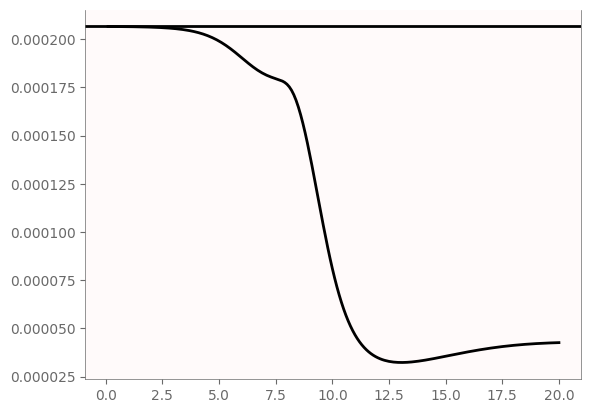

In [156]:
K_0 = 2.067E-4
velocity = get_mean_velocity()
fig, ax  = plt.subplots()
ax.plot(scalar.t/86400, -velocity)
ax.axhline(y=K_0)
plt.show()

In [157]:
labels = ["XAR","XDN","XN","EPS","XI"]
biomasses = np.array([get_total_biomass(i) for i in labels])

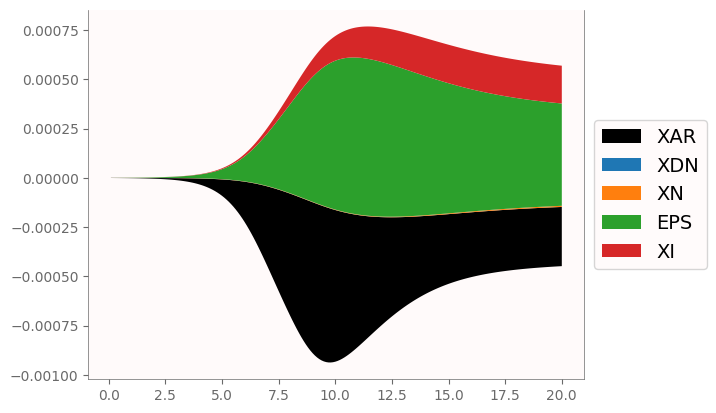

In [160]:

fig, ax  = plt.subplots()
# ax.plot(scalar.t/86400, get_total_biomass("XAR"))
# ax.plot(scalar.t/86400, get_total_biomass("XDN"))
# ax.plot(scalar.t/86400, get_total_biomass("XN"))
ax.stackplot(scalar.t/86400, *biomasses, labels = labels, baseline="wiggle")
#ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


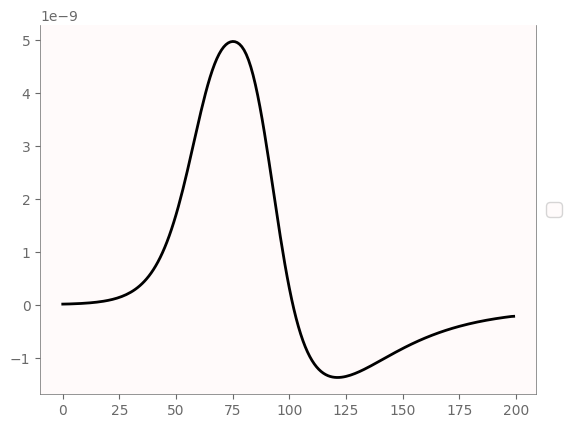

In [162]:
fig, ax  = plt.subplots()
#ax.plot(scalar.t/86400, np.sum(biomasses, axis=0))
ax.plot(np.gradient(np.sum(biomasses, axis=0), scalar.t))
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
#ax.set_yscale('log')
plt.show()

In [188]:
## Careful with this gradient, might need a very fine mesh 
## to solve for such an abrupt change

labels = ["DOC","NO3","NH4","O2"]
initConc = [10,2,1,9]
probes = [get_probe(i) for i in labels]

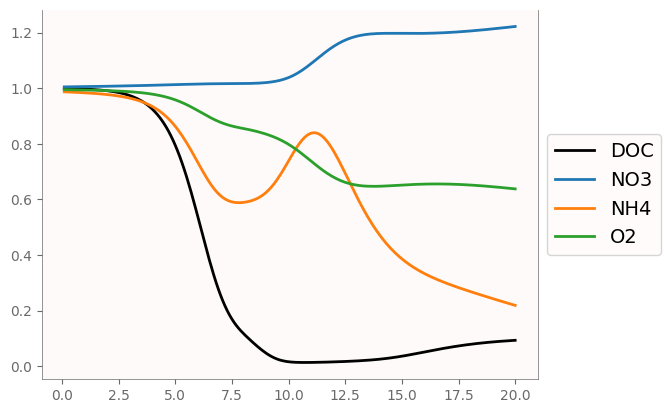

In [190]:
fig, ax  = plt.subplots()
#ax.plot(scalar.t/86400, np.sum(biomasses, axis=0))
for i, probe in enumerate(probes):
    ax.plot(scalar.t/86400, probe/(initConc[i]*1.0E-3), label=labels[i])

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()